## Importing Libraries

In [ ]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
 
%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import zipfile
import seaborn as sns 

In [ ]:
seed_constant = 42
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# Download and Extract Dataset

In [ ]:
!wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar

--2022-07-30 16:09:54--  http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
Resolving serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)... 128.148.254.114
Connecting to serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)|128.148.254.114|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar [following]
--2022-07-30 16:09:55--  https://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
Connecting to serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)|128.148.254.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2124008126 (2.0G)
Saving to: ‘hmdb51_org.rar’

hmdb51_org.rar      100%[===================>]   1.98G  13.5MB/s    in 3m 54s  

2022-07-30 16:13:50 (8.65 MB/s) - ‘hmdb51_org.rar’ saved [2124008126/2124008126]



In [ ]:
!unrar x "/content/hmdb51_org.rar" "/content/hmdb51_org/"

In [ ]:
path = "/content/hmdb51_org"
dest = "/content/dataset"
print(os.listdir(path))

for rarfile in os.listdir(path):
  unraredfile = rarfile[:-4]
  from_ = os.path.join(path, rarfile)
  to_ = os.path.join(dest, unraredfile , "")
  #print(to_)
  !unrar x "/content/hmdb51_org/{rarfile}" "/content/dataset/"

# Functions

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = r"/content/dataset"
CLASSES_LIST = []

NUMBER_OF_CLASSES = 10  # due to high RAM usage, I limit the class number to 10

c=0
for i in os.listdir(DATASET_DIR):
    CLASSES_LIST.append(i)
    c=c+1
    if c == NUMBER_OF_CLASSES:   # first 10 class will be trained 
        break


# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
print(CLASSES_LIST)
print("number of classes: " + str(NUMBER_OF_CLASSES))

['cartwheel', 'clap', 'swing_baseball', 'shake_hands', 'chew', 'climb_stairs', 'draw_sword', 'pick', 'throw', 'situp']
number of classes: 10


In [ ]:
def frames_extraction(video_path):

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255.0
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

In [ ]:
def create_dataset():

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: cartwheel
Extracting Data of Class: clap
Extracting Data of Class: swing_baseball
Extracting Data of Class: shake_hands
Extracting Data of Class: chew
Extracting Data of Class: climb_stairs
Extracting Data of Class: draw_sword
Extracting Data of Class: pick
Extracting Data of Class: throw
Extracting Data of Class: situp


In [ ]:
labels

array([0, 0, 0, ..., 9, 9, 9])

In [ ]:
unique_labels = set(labels)
print(unique_labels)   # How many unique classes are there?

print(len(labels))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
1173


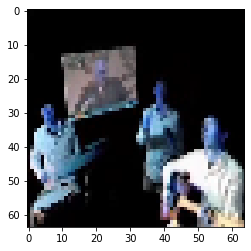

In [ ]:
plt.imshow(features[110][5])

In [ ]:
features.shape   # 1173 videos, 30 frames each video, 64x64x3 pixel each frame

(1173, 30, 64, 64, 3)

In [ ]:
labels.shape # 1173 videos have 1173 labels (1 for each)

(1173,)

In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
print(labels)   # sequential numbers indicate that classes are not shuffled yet

[0 0 0 ... 9 9 9]


In [ ]:
print(labels[500])
print(one_hot_encoded_labels[500])    # to ensure

3
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.333, shuffle = True, random_state = seed_constant)  # dataset is shuffled here, %33 of dataset will be for test

In [ ]:
features_train, features_valid, labels_train, labels_valid = train_test_split(features_train, labels_train, test_size = 0.1, shuffle = True, random_state = 558)  # for validation split

In [ ]:
print(features_train.shape)
print(features_test.shape)
print(features_valid.shape)

(703, 30, 64, 64, 3)
(391, 30, 64, 64, 3)
(79, 30, 64, 64, 3)


## Building Model

In [ ]:
input_shape = features_train.shape[1:]

model = Sequential()

model.add(Conv3D(8, 3, activation="relu", input_shape=input_shape))
model.add(MaxPool3D(pool_size=(2, 2, 2)))
model.add(SpatialDropout3D(0.33))


model.add(Conv3D(8, 3, activation="relu"))
model.add(MaxPool3D(pool_size=(2, 2, 2)))
model.add(SpatialDropout3D(0.33))


model.add(Conv3D(8, 3, activation="relu"))
model.add(SpatialDropout3D(0.33))


model.add(Flatten())

model.add(Dense(64, activation = "relu"))

model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 28, 62, 62, 8)     656       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 14, 31, 31, 8)    0         
 )                                                               
                                                                 
 spatial_dropout3d (SpatialD  (None, 14, 31, 31, 8)    0         
 ropout3D)                                                       
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 29, 29, 8)     1736      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 14, 14, 8)     0         
 3D)                                                             
                                                        

In [ ]:
# Compile the model and specify loss function, optimizer and metrics values to the model
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start training the model.
history = model.fit(x = features_train, y = labels_train, validation_data=(features_valid,labels_valid), epochs = 20, batch_size = 4)

Epoch 1/20
176/176 [==============================] - 14s 18ms/step - loss: 2.3037 - accuracy: 0.1181 - val_loss: 2.2922 - val_accuracy: 0.1266
Epoch 2/20
176/176 [==============================] - 3s 14ms/step - loss: 2.2697 - accuracy: 0.1479 - val_loss: 2.2649 - val_accuracy: 0.1899
Epoch 3/20
176/176 [==============================] - 2s 14ms/step - loss: 2.2125 - accuracy: 0.2048 - val_loss: 2.2184 - val_accuracy: 0.2025
Epoch 4/20
176/176 [==============================] - 2s 14ms/step - loss: 2.0765 - accuracy: 0.2788 - val_loss: 2.0781 - val_accuracy: 0.2785
Epoch 5/20
176/176 [==============================] - 3s 14ms/step - loss: 1.9492 - accuracy: 0.3286 - val_loss: 2.0124 - val_accuracy: 0.3671
Epoch 6/20
176/176 [==============================] - 2s 14ms/step - loss: 1.7512 - accuracy: 0.3869 - val_loss: 1.9659 - val_accuracy: 0.3671
Epoch 7/20
176/176 [==============================] - 2s 14ms/step - loss: 1.6242 - accuracy: 0.4979 - val_loss: 1.9457 - val_accuracy: 0.316

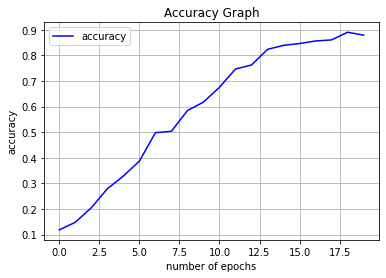

In [ ]:
plt.plot(history.history["accuracy"],color="b",label="accuracy")
plt.title("Accuracy Graph")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

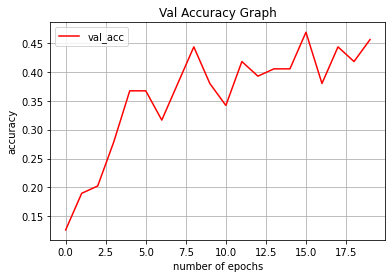

In [ ]:
plt.plot(history.history["val_accuracy"],color="r",label="val_acc")
plt.title("Val Accuracy Graph")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

In [ ]:
model.evaluate(x=features_test, y=labels_test)

13/13 [==============================] - 1s 39ms/step - loss: 4.8824 - accuracy: 0.4015


[4.882418632507324, 0.4015345275402069]

## Save the Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save("/content/drive/MyDrive/.../my_model")

## Confusion Matrix

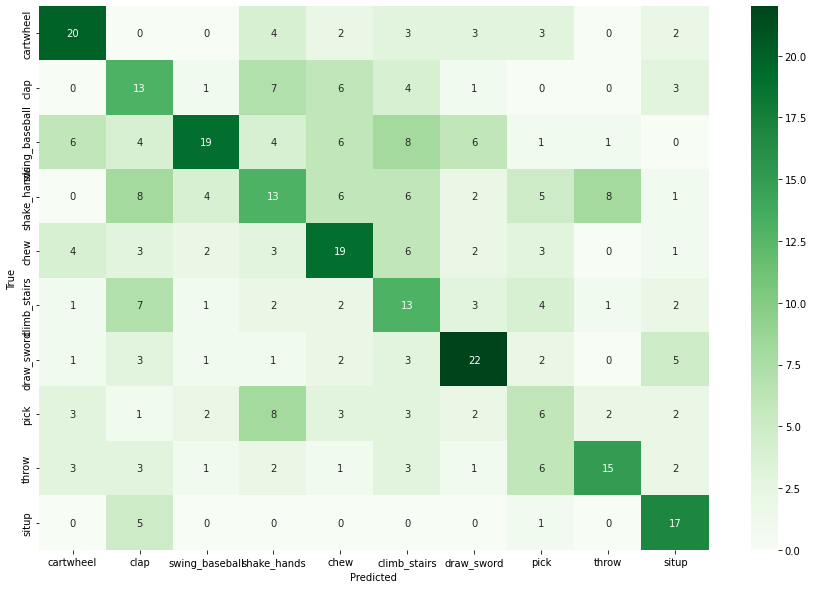

In [ ]:
#confusion matrix

y_pred = model.predict(features_test)
y_true = labels_test

#print(y_pred.shape)
#print(y_true.shape)

conf_mat = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))


f,ax=plt.subplots(figsize=(15,10))
sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap="Greens")

class_names = CLASSES_LIST

ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [ ]:
#accuracy: 0.4015